# Edge Detection Notebook
This notebook is intended to explore and compare the different edge detection schemes proposed

In [109]:
import pandas as pd

edges = pd.read_csv('base_graphs/suba/pre_quarantine.csv')
nodes = pd.concat((edges[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), edges[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
nodes = nodes.drop_duplicates()
nodes.shape[0]

7261

In [4]:
# Loads the different libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
import igraph as ig
# Starts the client
client = bigquery.Client(location="US")
import seaborn as sns
from datetime import timedelta

import matplotlib.pyplot as plt

import geopandas
import contextily as ctx

date_format = "%Y-%m-%d"

## Functions

In [5]:
def compute_personalized_pagerank(nodes, edges, weighted):
    '''
    Computes personalized pagerank. Nodes must have weight attribute
    '''
    
    # Create the graph
    G = ig.Graph()

    # Adds the values
    G.add_vertices(nodes.identifier.values)        

    if edges.shape[0] > 0:
        G.add_edges(edges.apply(lambda df: (df.id1, df.id2), axis = 1))
    
    if weighted:
        # Adds weights to edges
        G.es['weight'] = edges.weight.values

        # Exctracs the personalized pagerank
        personalized_page_rank = G.personalized_pagerank(weights = 'weight', directed = False, reset = nodes['dist_weight'].values)
    
    else:
        personalized_page_rank = G.personalized_pagerank(directed = False, reset = nodes['dist_weight'].values)
        
    # Returns the value
    return(personalized_page_rank)


def compute_pagerank(nodes, edges, weighted):
    
    
    # Create the graph
    G = ig.Graph()

    # Adds the values
    G.add_vertices(nodes.identifier.values)        

    if edges.shape[0] > 0:
        G.add_edges(edges.apply(lambda df: (df.id1, df.id2), axis = 1))
    
    if weighted:
        # Adds weights to edges
        G.es['weight'] = edges.weight.values

        # Exctracs the personalized pagerank
        page_rank = G.pagerank(weights = 'weight', directed = False)
    
    else:
        page_rank = G.pagerank(directed = False)
        
    # Returns the value
    return(page_rank)    


    
def compute_eigenvector(nodes, edges, weighted):
    '''
    Computes eigen vector
    '''
    
    # Create the graph
    G = ig.Graph()

    # Adds the values
    G.add_vertices(nodes.identifier.values)        

    if edges.shape[0] > 0:
        G.add_edges(edges.apply(lambda df: (df.id1, df.id2), axis = 1))
    
    if weighted:
        # Adds weights to edges
        G.es['weight'] = edges.weight.values

        # Exctracs the personalized pagerank
        eigen_vector = G.evcent(weights = 'weight', directed = False)
    
    else:
        # Exctracs the personalized pagerank
        eigen_vector = G.evcent(directed = False)
    
    # Returns the value
    return(eigen_vector)    
    
    
def compute_eigenvalue(nodes, edges, weighted):
    '''
    Computes personalized pagerank.
    '''
    
    # Create the graph
    G = ig.Graph()

    # Adds the values
    G.add_vertices(nodes.identifier.values)        

    if edges.shape[0] > 0:
        G.add_edges(edges.apply(lambda df: (df.id1, df.id2), axis = 1))

    if weighted:        
        # Adds weights to edges
        G.es['weight'] = edges.weight.values

        # Exctracs the eigen value
        _, eigen_value = G.evcent(weights = 'weight', directed = False, return_eigenvalue = True)

    else:

        # Exctracs the eigen value
        _, eigen_value = G.evcent(directed = False, return_eigenvalue = True)
        
    # Returns the value
    return(eigen_value)


def sort_edges_by_centrality(nodes, edges, centrality):
    
    df_centrality = pd.DataFrame({'val':centrality}, index = nodes.identifier)
    
    new_edges = edges.copy()
    new_edges['impact'] = df_centrality.loc[new_edges.id1, 'val'].values*df_centrality.loc[new_edges.id2, 'val'].values
    new_edges.sort_values('impact', ascending = False, inplace = True)
    
    return(new_edges)


def sort_edges(nodes, edges, method):
    '''
    Sorts the edges
    
    '''
    
    if method.upper() == 'RANDOM':
        return(edges.sample(edges.shape[0]))
    
    if method.upper() == 'EIGENVECTOR':
        
        centrality = compute_eigenvector(nodes, edges, weighted = False)
        return(sort_edges_by_centrality(nodes, edges, centrality))
    
    if method.upper() == 'PAGERANK':
        
        centrality = compute_pagerank(nodes, edges, weighted)
        return(sort_edges_by_centrality(nodes, edges, centrality))
    
    
    raise ValueError(f'Unsupported Method: {method}')
    
    
def get_edges(dataset_id, location_id, start_date, end_date ):
    
    
    # Edges 
    query = f"""
            SELECT id1, id2, COUNT(*) as weight, SUM(contacts) as total_contacts
            FROM grafos-alcaldia-bogota.{dataset_id}.{location_id}
            WHERE date >= "{start_date}" AND date <= "{end_date}"
            GROUP BY id1, id2
    """


    job_config = bigquery.QueryJobConfig(allow_large_results = True)
    query_job = client.query(query, job_config=job_config) 

    # Return the results as a pandas DataFrame
    edges = query_job.to_dataframe() 
    
    return(edges)

def get_nodes(location_id, start_date, end_date ):
    # Nodes

    query = f"""
            SELECT identifier
            FROM grafos-alcaldia-bogota.transits.hourly_transits
            WHERE location_id = "{location_id}"
                  AND date >= "{start_date}"
                  AND date <=  "{end_date}"
            GROUP BY identifier
    """


    job_config = bigquery.QueryJobConfig(allow_large_results = True)
    query_job = client.query(query, job_config=job_config) 

    # Return the results as a pandas DataFrame
    nodes = query_job.to_dataframe() 
    
    return(nodes)
    
    
def get_contacts(dataset_id, location_id, date, hour):
    '''
    Extracts the contacts of the given lo cation at date and hour
    '''
    
    # Edges 
    query = f"""
            SELECT id1, id2, lat, lon
            FROM grafos-alcaldia-bogota.{dataset_id}.{location_id}
            WHERE date = "{date}" AND hour = {hour}

    """


    job_config = bigquery.QueryJobConfig(allow_large_results = True)
    query_job = client.query(query, job_config=job_config) 

    # Return the results as a pandas DataFrame
    edges = query_job.to_dataframe() 
    
    return(edges)



def get_contacs_by_location(dataset_id, location_id, start_date, end_date):
    '''
    Extracts the contacts of the given lo cation at date and hour
    '''
    
    # Edges 
    query = f"""
            SELECT lat, lon, COUNT(*) total_contacts
            FROM
            (
              SELECT  ROUND(lat,4) AS lat, ROUND(lon,4) AS lon
              FROM grafos-alcaldia-bogota.{dataset_id}.{location_id}
              WHERE date >= "{start_date}" AND date <= "{end_date}"

            )
            GROUP BY lat, lon
            ORDER BY total_contacts DESC

    """


    job_config = bigquery.QueryJobConfig(allow_large_results = True)
    query_job = client.query(query, job_config=job_config) 

    # Return the results as a pandas DataFrame
    edges = query_job.to_dataframe() 
    
    return(edges)
    

# Creates the three Graphs For Edge Deletion

In [101]:
location_id = 'colombia_bogota_localidad_suba'
dataset_id = 'edgelists_bogota_localities'


In [102]:
# Pre quarantine
start_date =  pd.to_datetime("2020-03-05")
end_date =  pd.to_datetime("2020-03-11")

print('Pre')
print('   Extracting Edges')
df_pre = get_edges(dataset_id, location_id, start_date.strftime(date_format), end_date.strftime(date_format) )


print('   Extracting Nodes')
df_pre_nodes = pd.concat((df_pre[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_pre[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
df_pre_nodes = df_pre_nodes.drop_duplicates()

# Create the graph
G = ig.Graph()

# Adds the values
G.add_vertices(df_pre_nodes.identifier.values)        
G.add_edges(df_pre.apply(lambda df: (df.id1, df.id2), axis = 1))

degrees = np.array(G.indegree()) + np.array(G.outdegree())
    
print(f"   {start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}.  Nodes: {df_pre_nodes.shape[0]} Edges: {df_pre.shape[0]} Min Degree: {np.min(degrees)} Max Degree: {np.max(degrees)} Mean Degree: {np.round(np.mean(degrees),2)}")

print('')



Pre
   Extracting Edges
   Extracting Nodes
   2020-03-05 - 2020-03-11.  Nodes: 7261 Edges: 31928 Min Degree: 2 Max Degree: 702 Mean Degree: 17.59



In [103]:

# quarantine
start_date =  pd.to_datetime("2020-04-12")
end_date =  pd.to_datetime("2020-04-18")

print('Quarantine')
print('   Extracting Edges')
df_quar = get_edges(dataset_id, location_id, start_date.strftime(date_format), end_date.strftime(date_format) )


print('   Extracting Nodes')
df_quar_nodes = pd.concat((df_quar[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_quar[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
df_quar_nodes = df_quar_nodes.drop_duplicates()

# Create the graph
G = ig.Graph()

# Adds the values
G.add_vertices(df_quar_nodes.identifier.values)        
G.add_edges(df_quar.apply(lambda df: (df.id1, df.id2), axis = 1))

degrees = np.array(G.indegree()) + np.array(G.outdegree())
    
print(f"   {start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}.  Nodes: {df_quar_nodes.shape[0]} Edges: {df_quar.shape[0]} Min Degree: {np.min(degrees)} Max Degree: {np.max(degrees)} Mean Degree: {np.round(np.mean(degrees),2)}")


print('')

Quarantine
   Extracting Edges
   Extracting Nodes
   2020-04-12 - 2020-04-18.  Nodes: 8276 Edges: 13454 Min Degree: 2 Max Degree: 192 Mean Degree: 6.5



In [104]:

# Pos
start_date =  pd.to_datetime("2020-07-10")
end_date =  pd.to_datetime("2020-07-16")

print('Pos')
print('   Extracting Edges')
df_pos = get_edges(dataset_id, location_id, start_date.strftime(date_format), end_date.strftime(date_format) )


print('   Extracting Nodes')
df_pos_nodes = pd.concat((df_pos[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_pos[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
df_pos_nodes = df_pos_nodes.drop_duplicates()

# Create the graph
G = ig.Graph()

# Adds the values
G.add_vertices(df_pos_nodes.identifier.values)        
G.add_edges(df_pos.apply(lambda df: (df.id1, df.id2), axis = 1))



degrees = np.array(G.indegree()) + np.array(G.outdegree())
    
print(f"   {start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}.  Nodes: {df_pos_nodes.shape[0]} Edges: {df_pos.shape[0]} Min Degree: {np.min(degrees)} Max Degree: {np.max(degrees)} Mean Degree: {np.round(np.mean(degrees),2)}")


print('')



Pos
   Extracting Edges
   Extracting Nodes
   2020-07-10 - 2020-07-16.  Nodes: 8500 Edges: 27060 Min Degree: 2 Max Degree: 514 Mean Degree: 12.73



In [105]:

# Extracts final graphs
print('   Saving')
df_pre.to_csv('base_graphs/suba/edgelists/pre_quarantine.csv', index = False)

print('   Saving')
df_quar.to_csv('base_graphs/suba/edgelists/quarantine.csv', index = False)

print('   Saving')
df_pos.to_csv('base_graphs/suba/edgelists/pos_quarantine.csv', index = False)


# Saves Nodes
df_all_nodes = pd.concat((df_pre_nodes,df_quar_nodes, df_pos_nodes ), ignore_index = True).drop_duplicates()

print(f'Total Nodes: {df_all_nodes.shape[0]}')

df_all_nodes.to_csv('base_graphs/suba/nodes.csv', index = False) 

print('Done')


   Saving
   Saving
   Saving
Total Nodes: 23043
Done


In [12]:
# Extract Final Nodes
df_nodes = df_pre_nodes.merge(df_quar_nodes, on =  'identifier')
df_nodes = df_nodes.merge(df_pos_nodes, on =  'identifier')
    
finished = False
while not finished:

    final_nodes = set(df_nodes.identifier.values)
    initial_size = df_nodes.shape[0]

    # Filters edges
    df_pre = df_pre[(df_pre.id1.isin(final_nodes)) & (df_pre.id2.isin(final_nodes))]
    df_quar = df_quar[(df_quar.id1.isin(final_nodes)) & (df_quar.id2.isin(final_nodes))]
    df_pos = df_pos[(df_pos.id1.isin(final_nodes)) & (df_pos.id2.isin(final_nodes))]
    
    
    # Filters Nodes
    df_pre_nodes = pd.concat((df_pre[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_pre[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
    df_pre_nodes = df_pre_nodes.drop_duplicates()

    df_quar_nodes = pd.concat((df_quar[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_quar[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
    df_quar_nodes = df_quar_nodes.drop_duplicates()
    
    df_pos_nodes = pd.concat((df_pos[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_pos[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
    df_pos_nodes = df_pos_nodes.drop_duplicates()
    
    
    # Extract Final Nodes
    df_nodes = df_pre_nodes.merge(df_quar_nodes, on =  'identifier')
    df_nodes = df_nodes.merge(df_pos_nodes, on =  'identifier')
    
    print(f'Initial Size: {initial_size}')
    print(f'Final Size: {df_nodes.shape[0]}')
    print('')
    
    if initial_size == df_nodes.shape[0]:
        finished = True

    




Initial Size: 1870
Final Size: 1870



In [100]:
s_date =  pd.to_datetime("2020-02-01")
e_date =  pd.to_datetime("2020-08-15")

current = s_date

while current < e_date:

    # Pos
    start_date =  current
    end_date =  current + timedelta(days = 6)

    #print('Pos')
    #print('   Extracting Edges')
    df_pos = get_edges(dataset_id, location_id, start_date.strftime(date_format), end_date.strftime(date_format) )


    #print('   Extracting Nodes')
    df_pos_nodes = pd.concat((df_pos[['id1']].drop_duplicates().rename(columns = {'id1':'identifier'}), df_pos[['id2']].drop_duplicates().rename(columns = {'id2':'identifier'})), ignore_index = True)
    df_pos_nodes = df_pos_nodes.drop_duplicates()

    # Create the graph
    G = ig.Graph()

    # Adds the values
    G.add_vertices(df_pos_nodes.identifier.values)        
    G.add_edges(df_pos.apply(lambda df: (df.id1, df.id2), axis = 1))

    degrees = np.array(G.indegree()) + np.array(G.outdegree())
    
    
    print(f"   {start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}.  Nodes: {df_pos_nodes.shape[0]} Edges: {df_pos.shape[0]} Min Degree: {np.min(degrees)} Max Degree: {np.max(degrees)} Mean Degree: {np.round(np.mean(degrees),2)}")
    
    current = current + timedelta(days = 1)
    
    #print('')

   2020-02-01 - 2020-02-07.  Nodes: 6502 Edges: 10110 Min Degree: 2 Max Degree: 128 Mean Degree: 6.22
   2020-02-02 - 2020-02-08.  Nodes: 6344 Edges: 9169 Min Degree: 2 Max Degree: 120 Mean Degree: 5.78
   2020-02-03 - 2020-02-09.  Nodes: 7017 Edges: 10238 Min Degree: 2 Max Degree: 140 Mean Degree: 5.84
   2020-02-04 - 2020-02-10.  Nodes: 7011 Edges: 10283 Min Degree: 2 Max Degree: 134 Mean Degree: 5.87
   2020-02-05 - 2020-02-11.  Nodes: 6674 Edges: 9505 Min Degree: 2 Max Degree: 128 Mean Degree: 5.7
   2020-02-06 - 2020-02-12.  Nodes: 6400 Edges: 8948 Min Degree: 2 Max Degree: 122 Mean Degree: 5.59
   2020-02-07 - 2020-02-13.  Nodes: 6385 Edges: 8682 Min Degree: 2 Max Degree: 128 Mean Degree: 5.44
   2020-02-08 - 2020-02-14.  Nodes: 6170 Edges: 8291 Min Degree: 2 Max Degree: 130 Mean Degree: 5.38
   2020-02-09 - 2020-02-15.  Nodes: 5952 Edges: 8077 Min Degree: 2 Max Degree: 140 Mean Degree: 5.43
   2020-02-10 - 2020-02-16.  Nodes: 5584 Edges: 7499 Min Degree: 2 Max Degree: 114 Mean D

In [12]:


# Extracts final graphs
print('   Saving')
df_pre.to_csv('base_graphs/edgelists/pre_quarantine.csv', index = False)

print('   Saving')
df_quar.to_csv('base_graphs/edgelists/quarantine.csv', index = False)

print('   Saving')
df_pos.to_csv('base_graphs/edgelists/pos_quarantine.csv', index = False)


# Saves Nodes
df_all_nodes = pd.concat((df_pre_nodes,df_quar_nodes, df_pos_nodes ), ignore_index = True).drop_duplicates()

print(f'Total Nodes: {df_all_nodes.shape[0]}')

df_all_nodes.to_csv('base_graphs/nodes.csv', index = False) 

print('Done')

Total Nodes: 268687
Done


## Starts Procedure

In [3]:
# Loads the graph
weighted = False
location_id = 'colombia_cucuta'
dataset_id = 'edgelists_cities'
start_date =  pd.to_datetime("2020-07-28")
end_date =  pd.to_datetime("2020-08-28")


In [4]:
methods = ['random','eigenvector','pagerank']
step = 0.05
max_remove = 0.6


percentages = np.arange(0,max_remove,step)

results = []
current_date = start_date
days_step = 3
days_window = 7
while current_date <= end_date:
    
    start_date_string = (current_date - timedelta(days = days_window)).strftime(date_format)
    end_date_string = current_date.strftime(date_format)
    
    print(f'Computing from: {start_date_string} to {end_date_string}')
    
    nodes = get_nodes(location_id, start_date_string, end_date_string )
    edges = get_edges(dataset_id, location_id, start_date_string, end_date_string)
    
    print(f'   Nodes: {nodes.shape[0]}')
    print(f'   Edges: {edges.shape[0]}')
    
    initial_eigenvalue = compute_eigenvalue(nodes, edges, weighted)
    
    for method in methods:

        print(f'   Method: {method}')
        new_edges = sort_edges(nodes, edges, method)

        new_eigenvalues = []
        for per in percentages:
            #print(f'      Percentage: {per}')
            chunk = int(np.round(new_edges.shape[0]*per))
            e = compute_eigenvalue(nodes, new_edges.iloc[chunk:], weighted)
            results.append({'method':method, 'percentage':per, 'value':e, 'change':100*(e-initial_eigenvalue)/initial_eigenvalue})
    
    current_date = current_date + timedelta(days = days_step)
print('Done')                        

df_results = pd.DataFrame(results)

Computing from: 2020-07-21 to 2020-07-28
   Nodes: 20725
   Edges: 14919
   Method: random


KeyboardInterrupt: 

In [7]:
df_results.to_csv('cucuta.csv')

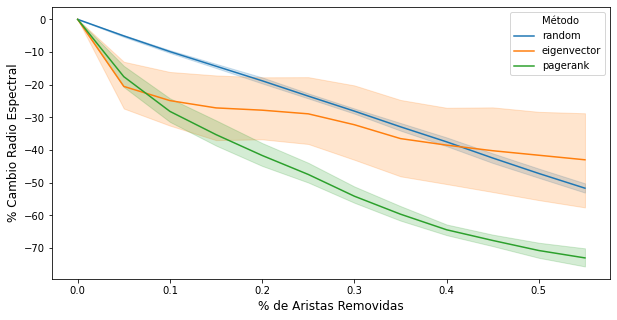

In [8]:
df_results = pd.read_csv('cucuta.csv')
plt.figure(figsize=(10,5))
ax = sns.lineplot(data = df_results, x = 'percentage', y = 'change', hue = 'method')
ax.set_ylabel('% Cambio Radio Espectral', fontsize=12)
ax.set_xlabel('% de Aristas Removidas', fontsize=12)
ax.legend().texts[0].set_text("Método")

## Edge Detection

In [5]:
location_pagerank = []
location_count = []

percentage = 0.1

round_number = 4 # 15m

#start_date =  pd.to_datetime("2020-07-01")
#end_date =  pd.to_datetime("2020-07-30")


current_date = start_date
while current_date <= end_date:
    
    current_date_string = current_date.strftime(date_format)
    
    print(f'Date: {current_date_string}')
        
    for hour in range(6,22):
        
        #print(f'   Hour:{hour}')
        
        edges = get_contacts(dataset_id, location_id, current_date_string, hour)        
        nodes = pd.concat((edges[['id1']].rename(columns = {'id1':'identifier'}), edges[['id2']].rename(columns = {'id2':'identifier'})), ignore_index = True).drop_duplicates()
        
        new_edges = sort_edges(nodes, edges, 'pagerank')
        
        # Extract location
        chunk = int(np.ceil(new_edges.shape[0]*percentage))
        df_temp = new_edges.iloc[0:chunk]

        # Selects lat and lon
        df_temp = df_temp[['lat','lon']].copy()
        df_temp['total'] = 1
        df_temp = df_temp.groupby(['lat','lon']).sum().reset_index()
        
        # Adds the timestamp
        df_temp['date'] = current_date
        df_temp['hour'] = hour              
        
        location_pagerank.append(df_temp)

    
    current_date = current_date + timedelta(days = 1)
    
    
df_locations_pagerank = pd.concat(location_pagerank, ignore_index = True)


Date: 2020-07-28
Date: 2020-07-29
Date: 2020-07-30
Date: 2020-07-31
Date: 2020-08-01
Date: 2020-08-02
Date: 2020-08-03
Date: 2020-08-04
Date: 2020-08-05
Date: 2020-08-06
Date: 2020-08-07
Date: 2020-08-08
Date: 2020-08-09
Date: 2020-08-10
Date: 2020-08-11
Date: 2020-08-12
Date: 2020-08-13
Date: 2020-08-14
Date: 2020-08-15
Date: 2020-08-16
Date: 2020-08-17
Date: 2020-08-18
Date: 2020-08-19
Date: 2020-08-20
Date: 2020-08-21
Date: 2020-08-22
Date: 2020-08-23
Date: 2020-08-24
Date: 2020-08-25
Date: 2020-08-26
Date: 2020-08-27
Date: 2020-08-28


In [6]:
eps = 0.001
total_places = 10

In [7]:
df_locations = get_contacs_by_location(dataset_id, location_id, start_date.strftime(date_format), end_date.strftime(date_format))
df_locations = df_locations.head(total_places)

df1 = df_locations[['lat','lon','total_contacts']].rename(columns = {'total_contacts':'total'})

# Adds noise
df1.lat = df1.lat + np.random.normal(0,eps,df1.shape[0])
df1.lon = df1.lon + np.random.normal(0,eps,df1.shape[0])


geo_locations = geopandas.GeoDataFrame(df1,crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df1.lon, df1.lat))
geo_locations = geo_locations.to_crs(epsg=3857)

In [8]:
df2 = df_locations_pagerank[['lat','lon','total']].copy()
df2.lon = df2.lon.round(round_number)
df2.lat = df2.lat.round(round_number)

df2 = df2.groupby(['lat','lon']).sum().reset_index().sort_values('total', ascending = False).head(total_places)

df2.lat = df2.lat + np.random.normal(0,eps,df2.shape[0])
df2.lon = df2.lon + np.random.normal(0,eps,df2.shape[0])

geo_pagerank = geopandas.GeoDataFrame(df2,crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df2.lon, df2.lat))
geo_pagerank = geo_pagerank.to_crs(epsg=3857)

In [9]:
df3 = df_locations_pagerank[['lat','lon','total']].copy()
df3 = df3.groupby(['lat','lon']).sum().reset_index()

geo_pagerank_trace = geopandas.GeoDataFrame(df3,crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df3.lon, df3.lat))
geo_pagerank_trace = geo_pagerank_trace.to_crs(epsg=3857)

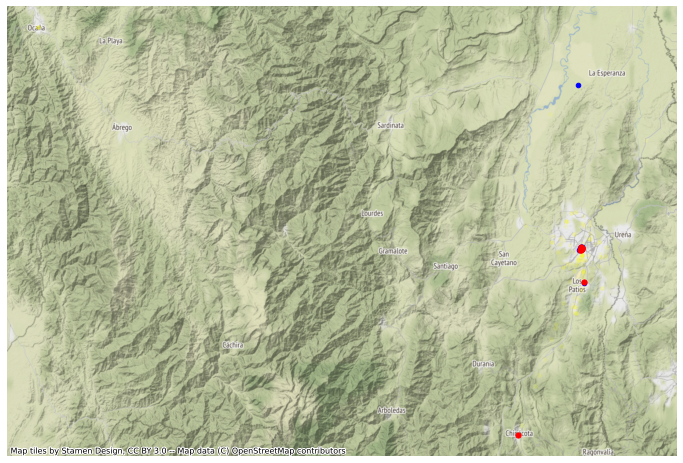

In [11]:
ax = geo_pagerank_trace.plot(figsize=(12, 12), alpha=0.1, markersize = 12, color = 'yellow')
geo_pagerank.plot(alpha=1, markersize = 21, color = 'blue', ax = ax)
geo_locations.plot(alpha=1, markersize = 27, color = 'red', ax = ax)
ctx.add_basemap(ax)
ax.set_axis_off()

In [15]:
geo_locations

,lat,lon,total,geometry
0,7.896627,-72.506680,4112113,POINT (-8071406.643 881844.741)
1,7.895389,-72.505901,3922021,POINT (-8071320.033 881705.600)
2,7.894264,-72.505623,1142809,POINT (-8071289.071 881579.104)
3,7.895411,-72.505755,468387,POINT (-8071303.716 881708.065)
4,7.893069,-72.507485,163356,POINT (-8071496.285 881444.829)
5,7.891918,-72.508489,147529,POINT (-8071608.108 881315.520)
6,7.893555,-72.507777,123639,POINT (-8071528.768 881499.489)
7,7.894164,-72.506768,19776,POINT (-8071416.442 881567.919)
8,7.605602,-72.605826,646,POINT (-8082443.547 849149.137)
9,7.842344,-72.502764,573,POINT (-8070970.804 875744.517)


In [16]:
def filter(df_geo, min_lat, max_lat, min_lon, max_lon):
    resp = df_geo[(df_geo.lat >= min_lat) & (df_geo.lat <= max_lat)].copy()
    resp = resp[(resp.lon >= min_lon) & (resp.lon <= max_lon)]
    return(resp)
    

In [17]:
min_lat = 7.7
max_lat = 8

min_lon = -73
max_lon = -70

geo_pagerank_f = filter(geo_pagerank, min_lat, max_lat, min_lon, max_lon)
geo_pagerank_trace_f = filter(geo_pagerank_trace, min_lat, max_lat, min_lon, max_lon)
geo_locations_f = filter(geo_locations, min_lat, max_lat, min_lon, max_lon)

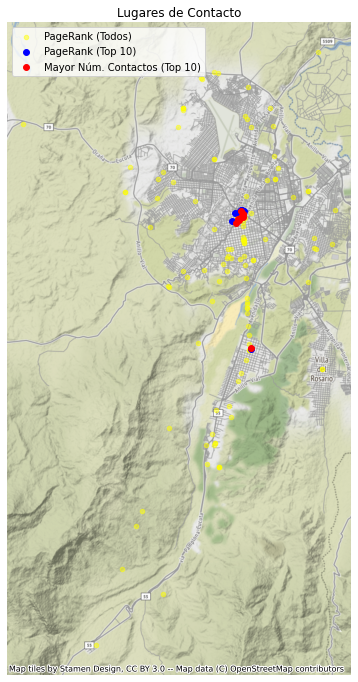

In [20]:
ax = geo_pagerank_trace_f.plot(figsize=(12, 12), alpha=0.5, markersize = 20, color = 'yellow', label = 'PageRank (Todos)')
geo_pagerank_f.plot(alpha=1, markersize = 35, color = 'blue', ax = ax, label = 'PageRank (Top 10)')
geo_locations_f.plot(alpha=1, markersize = 35, color = 'red', ax = ax, label = 'Mayor Núm. Contactos (Top 10)')
ctx.add_basemap(ax)
ax.set_axis_off()
ax.set_title('Lugares de Contacto')
ax.legend()

In [43]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])

In [168]:
geo_pagerank_trace_f

,lat,lon,total,geometry
0,4.545630,-74.158609,1,POINT (-8255298.592 506548.886)
1,4.590663,-74.070934,1,POINT (-8245538.655 511577.890)
2,4.591024,-74.079763,1,POINT (-8246521.440 511618.250)
3,4.593030,-74.088015,1,POINT (-8247440.104 511842.254)
4,4.601106,-74.070021,1,POINT (-8245437.021 512744.171)
5,4.602097,-74.065720,1,POINT (-8244958.236 512854.846)
6,4.602875,-74.069582,1,POINT (-8245388.152 512941.732)
7,4.603272,-74.068654,1,POINT (-8245284.847 512986.069)
8,4.603296,-74.068586,1,POINT (-8245277.277 512988.750)
9,4.603307,-74.068570,2,POINT (-8245275.496 512989.978)


In [52]:
np.arange(0.1,1,0.05)

AttributeError: module 'numpy' has no attribute 'inverse'

In [ ]:
percentages = 

,val
identifier,
4ae11209-760d-4763-883c-8092e5ee486b,5.291572e-15
50ea8573-eb47-498f-9e96-b82dc690a515,5.291572e-15
c6f79897-6b79-47de-8911-e5cc17c9bd89,5.291572e-15
d7d764ad-0d8e-457b-a122-babadf61c3c2,1.492935e-13
2d6e092c-f4c1-4eb5-a9d6-d0c795315b42,5.291572e-15
...,...
6bc39edf-e202-473e-9d02-6ef6345ecb1f,5.291572e-15
8a7b94ff-85d6-4da5-9e36-24ead4543c87,5.291572e-15
2613449c-f8f6-40ac-8cb0-b22c94823daf,5.291572e-15


In [44]:
step = 0.05
max_reduce = 0.4
new_edges = edges.copy()
new_edges['impact'] = df_centrality.loc[new_edges.id1, 'val'].values*df_centrality.loc[new_edges.id2, 'val'].values
new_edges.sort_values('impact', ascending = False, inplace = True)

chunk = int(np.round(new_edges.shape[0]*step))

new_eigenvalues = []
for i in range(int(max_reduce/step)):
    new_edges = new_edges.iloc[chunk:]
    e = compute_eigenvalue(nodes, new_edges, weighted)
    print(e)
    new_eigenvalues.append(e)

15.052994365366864
15.052994365367795
12.916566405231265
10.786572684491793
9.303934451357662
9.303934451357156
9.303934451358124
7.484835159692312


In [45]:
step = 0.05
max_reduce = 0.4
weighted = False
new_edges = edges.copy()
#new_edges['impact'] = df_centrality.loc[new_edges.id1, 'val'].values*df_centrality.loc[new_edges.id2, 'val'].values
new_edges.sort_values('weight', ascending = False, inplace = True)

chunk = int(np.round(new_edges.shape[0]*step))

new_eigenvalues = []
for i in range(int(max_reduce/step)):
    new_edges = new_edges.iloc[chunk:]
    e = compute_eigenvalue(nodes, new_edges, weighted)
    print(e)
    new_eigenvalues.append(e)

24.54681364371186
22.629300063702278
21.55902103455296
19.958755782714434
17.68402450218654
16.379730174337592
14.887767475880482
13.663399563843459


In [30]:
# Nodes  Weights (Proximity to Covid)
query = f"""
        with 
        -- Graph Ids
        graph_ids as (
             SELECT identifier
             FROM grafos-alcaldia-bogota.transits.hourly_transits
             WHERE location_id = "{location_id}"
                   AND date <= "{end_date}"
                   AND date >= "{start_date}"
             GROUP BY identifier
        ),
        -- Housing
        houses as (
          SELECT loc.identifier, lat,lon
          FROM grafos-alcaldia-bogota.housing_location.colombia_housing_location as loc
          JOIN graph_ids
          ON loc.identifier = graph_ids.identifier
          WHERE loc.week_date >= DATE_SUB(DATE("{end_date}"), INTERVAL 4 WEEK)
             AND loc.week_date <= "{end_date}"  -- Casas del ultimo mes
           ),

        -- Distance to infected
        distances as (
        SELECT identifier, MIN(distance) as distance_to_infected
        FROM
        (
         SELECT
         houses.identifier as identifier,
         ST_DISTANCE(ST_GEOGPOINT(houses.lon, houses.lat), infectados.geometry) as distance -- Distancia a infectado (en metros)
         FROM houses as houses -- Tabla con las casas
         CROSS JOIN (SELECT * FROM `servinf-unacast-prod.AlcaldiaBogota.positivos_agg_fecha` 
          where DATE(fec_con_cast) >= DATE_SUB(DATE("{end_date}"), INTERVAL 30 DAY) ) as infectados -- Tabla con los infectados (del ultimo mes)
         ) as d -- Matriz de distancia entre las casas y los infectados
         GROUP BY identifier -- Agrupa por el identificador para encontrar la minima distancia
         )


         -- Final Query
         SELECT graph_ids.identifier as identifier, distances.distance_to_infected as distance_to_infected
         FROM graph_ids
         LEFT JOIN distances
         ON graph_ids.identifier = distances.identifier
"""


job_config = bigquery.QueryJobConfig(allow_large_results =True)
query_job = client.query(query, job_config=job_config) 

# Return the results as a pandas DataFrame
node_weights = query_job.to_dataframe() 



# Apply inverted soft_plus
node_weights['weight'] = np.log(1 + np.exp(-1*node_weights['distance_to_infected']/div))/np.log(2)

# Merges with weights        
nodes = nodes.merge(node_weights, on = 'identifier', how = 'left')

nodes.fillna(0, inplace = True)

,id1,id2,weight
569,78f2320c-07b3-44fc-af30-51afdd793f0b,dd17f14b-b7f7-41b8-9316-f8b14a38e7a0,0.579037
567,31be5139-c3f4-4b1b-a021-aaf27650a27e,78f2320c-07b3-44fc-af30-51afdd793f0b,0.574127
484,78f2320c-07b3-44fc-af30-51afdd793f0b,aabd1eb0-c75d-40a2-b914-003beb34fef3,0.424523
558,08fc6288-2cd7-4930-b8bb-4cdd037cbfb1,78f2320c-07b3-44fc-af30-51afdd793f0b,0.414669
6382,000471bc-001d-4a04-90bb-05142ea18af7,dd17f14b-b7f7-41b8-9316-f8b14a38e7a0,0.346605
...,...,...,...
3052,07dd3860-d801-4744-8ae3-973e53593625,f54fb80d-9324-4678-89b4-d5de5b27b0ed,0.000000
3051,68c3ef61-42b2-4243-a5ef-d59954b29f3c,cb263c85-773a-45c2-9ebc-54d3f85444f9,0.000000
3050,60c82617-6d22-4560-ac83-7f0d75a99f9a,61b0d158-c329-4ba6-98c2-39e2110f5149,0.000000
3049,0c19f568-1ec3-41a5-9a05-0686ce312ece,956c5085-2a94-49fc-97db-35a75ee79db7,0.000000
